# "Normal" Autoencoders
We have already investigated "standard" autoencoders.   These autoencoders are designed to reproduce on output a high fidelity version of the input - but not by simply copying it.   They do this by compressing the input data using a neural network, with a narrow "bottleneck" layer in the middle.   This bottleneck layer - through training" - discovers a "compressed latent encoding".   As we have seen, this latent encoding can be used in a number of applications: compression, denoising, and (when the encoding and latent layers are fixed) used in a separate classification network.

A standard autoencoder is illustrated in the figure below.   The vector $z$ is the latent enocding of the input vector $X$.   This latent vector $z$ is a vector of $numbers$ - one value for each of the latent dimensions.

![standard autoencoder](standard_ae.jpeg)


Thinking of the encoder as a "recognition model" and the decoder as a "generative model" is interesting.   Could we use a standard autoencoder to generate new data?   This would be very helpful, especially if we needed new data for our supervised models.   What if wanted to sample the underlying latent vector space?   Variational autoencoders allow us to do this.

Some useful reading for this workbook:
1.  [Variational autoencoders.](https://www.jeremyjordan.me/variational-autoencoders/)
2.  [Using variational autoencoders to learn variations in data](https://news.sophos.com/en-us/2018/06/15/using-variational-autoencoders-to-learn-variations-in-data/)


## Get the data
For this task we will again use the standard MNIST sample that comes with Keras.

In [1]:
import keras
import tensorflow
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

short = False
if short:
    train_images = train_images[:7000,:]
    train_labels = train_labels[:7000]
    test_images = test_images[:3000,:]
    test_labels = test_labels[:3000]
#
print("Train info",train_images.shape, train_labels.shape)
print("Test info",test_images.shape, test_labels.shape)
train_images = train_images.reshape((train_images.shape[0],784))
train_images = train_images.astype('float32')/255

test_images = test_images.reshape((test_images.shape[0],784))
test_images = test_images.astype('float32')/255
from keras.utils import to_categorical

train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)


Using TensorFlow backend.


Train info (60000, 28, 28) (60000,)
Test info (10000, 28, 28) (10000,)


## A very simple autoencoder
Below we will make a very simple autoencoder using a fully connected network.   This network consists of the following:
1.  An input layer: This is just the 784 pixels from the image.
2.  The encoder: this layer has 784 inputs, an encoding_dim=256, and a bottleneck dimension of 2 (or more) outputs.
3.  The decoder: this layer takes the 2 outputs of the encoder as input, then has 784 outputs, just like the input to the encoder.



In [2]:
from keras import models
from keras import layers
from keras import regularizers

# this is the size of our encoded representations
encoding_dim = 256  
bottleneck_dim = 10 
#
# Define out model
network = models.Sequential()
#
# This is the "encoder"
network.add(layers.Dense(encoding_dim,activation='relu',input_shape=(28*28,)))
network.add(layers.Dense(bottleneck_dim,activation='relu'))
#
# This is the decoder
network.add(layers.Dense(28*28,activation='sigmoid'))
#
# Now compile the network!
network.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['mse'])
print("network: ",network.summary())

history = network.fit(train_images, train_images,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8624      
Total params: 212,154
Trainable params: 212,154
Non-trainable params: 0
_________________________________________________________________
network:  None
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 113us/step - loss: 0.3613 - mean_squared_error: 0.1016 - val_loss: 0.2693 - val_mean_squared_error: 0.0690
Epoch 2/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.2663 - mean_squared_error: 0.0677 - val_loss: 0.2624 - val_mean_squared_error: 0.0667

## Save the network
We may want to use this network later, so lets save it!   Use a reasonable name so we can tell what it is!

In [3]:
#print(history.history)
network.save('ae_fcn_bottleneck_'+str(bottleneck_dim)+'.h5')  # "tag" the file with the number of dimensions

## Performance
To examine performance, we can first look to see if our autoencoder is completely trained.   Lets look at loss and mean-squared error ("mse") for train vs test.

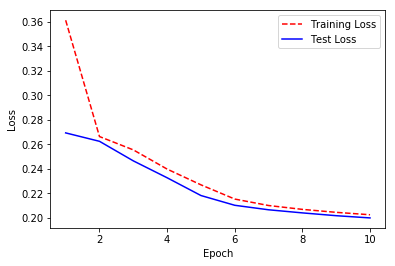

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

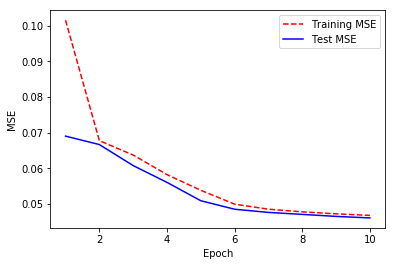

In [5]:
# Get training and test loss histories
training_loss = history.history['mean_squared_error']
test_loss = history.history['val_mean_squared_error']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training MSE', 'Test MSE'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show();

## Performance, Part II
Next we can try the "eye test": do the images at output look close to the images at input?

To test this, we first run all of our **test** (unseen by the network during training) images through the **predict** function of our network:

In [6]:
decoded_imgs = network.predict(test_images)
print("decoded_imgs.shape",decoded_imgs.shape)

decoded_imgs.shape (10000, 784)


## Performance, Part II (continued):
Now we can take a random set of digits (we use the first 10 below) from our test sample, and compare the original images with the output of our autoencoder for those same images.   Note that the output images look close - but there is some blurriness to them.  If the bottleneck dimension is very low (like 2) the images may even look incorrect (but close).

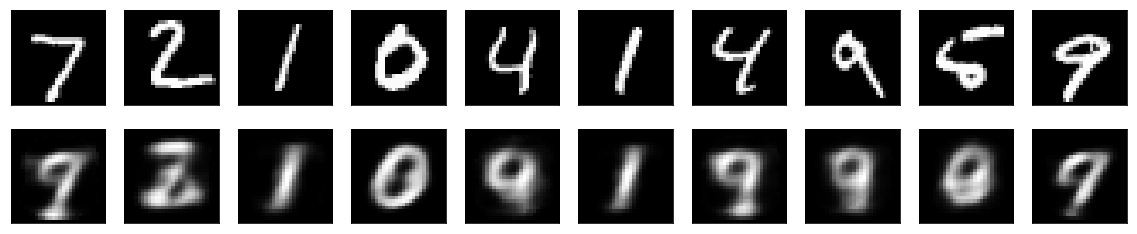

In [7]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Performance vs Bottleneck dimension
If we vary the bottle neck dimension from 2 to 40, we see, not unexpectedly, large changes in performance.

# Keras Functional API
Implementing the variational autoencoder can be done with keras, but it is a little tricky.  It turns out that it is much easier to implement using the Keras **functional API**.   For details on this, see [here](https://keras.io/models/model/).

To see how the functional API works, lets implement the exact same simple autoencoder as we did above

In [9]:
from keras import models
from keras import layers
from keras import regularizers
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

# this is the size of our encoded representations
original_dim = 28*28
encoding_dim = 256  
bottleneck_dim = 10  
batch_size = 100
epochs = 50

#
# Define out model
#network = models.Sequential()
#
# This is the "encoder" - "Old style"
#network.add(layers.Dense(encoding_dim,activation='relu',input_shape=(28*28,)))
#network.add(layers.Dense(bottleneck_dim,activation='relu'))
#
# The functional API requires that we explicitly define an input layer
x = Input(batch_shape=(batch_size, original_dim))
#
# These are the two layers we defined above
h1 = Dense(encoding_dim, activation='relu')(x)    # layer input is x, output is h1
h2 = Dense(bottleneck_dim, activation='relu')(h1)   # layer input is h1, output is h2
#
# This is the decoder
#network.add(layers.Dense(28*28,activation='sigmoid'))
x_decoded = Dense(original_dim, activation='sigmoid')(h2)   # layer input is h2, output is x_decoded
#
# We could use the standard "binary_crossentropy" function but this shows how to define your own!
def vae_loss(x, x_decoded):
    xent_loss = metrics.binary_crossentropy(x, x_decoded)
    return xent_loss
#
# Here we actually define the model
network = Model(inputs=x, outputs=x_decoded)

#
# Compiling is basically the same, except that we use our loss function
#network.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['mse'])
network.compile(optimizer='adadelta', loss=vae_loss,metrics=['mse'])
#
# Fitting is the same
history = network.fit(train_images, train_images,
                epochs=10,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_images, test_images))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.2924 - mean_squared_error: 0.0768 - val_loss: 0.2494 - val_mean_squared_error: 0.0616
Epoch 2/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.2274 - mean_squared_error: 0.0539 - val_loss: 0.2097 - val_mean_squared_error: 0.0483
Epoch 3/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.2008 - mean_squared_error: 0.0455 - val_loss: 0.1917 - val_mean_squared_error: 0.0428
Epoch 4/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.1883 - mean_squared_error: 0.0417 - val_loss: 0.1830 - val_mean_squared_error: 0.0402
Epoch 5/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.1825 - mean_squared_error: 0.0400 - val_loss: 0.1790 - val_mean_squared_error: 0.0390
Epoch 6/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.1788 - mean_squared_error: 0

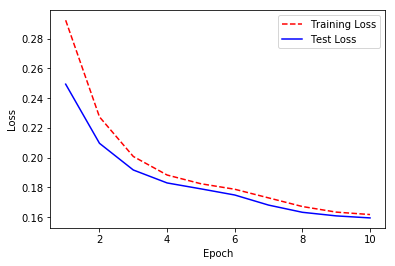

decoded_imgs.shape (10000, 784)


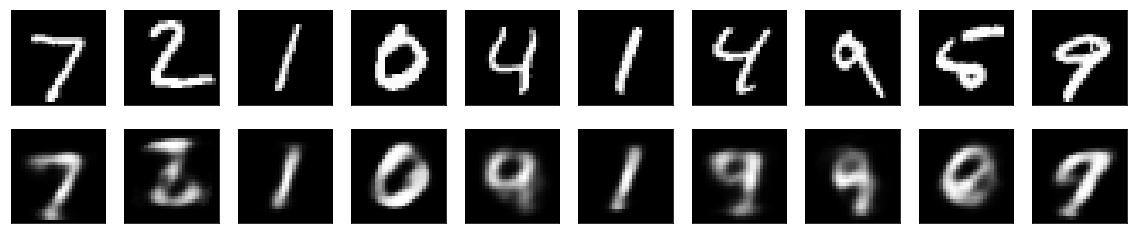

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


decoded_imgs = network.predict(test_images)
print("decoded_imgs.shape",decoded_imgs.shape)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Variational Autoencoders
Now let us try to use a different approach to determine the latent representation $z$.   Instead of each dimension in $z$ being a number (where the recognition model learns the mapping from $X$ to $z$), we instead use a representation where the each dimension in the vector $z$ is represented by a function.   This new model is shown in the figure below:


![variational autoencoder](vae_1.jpeg)

The idea is the following:
1.  We use the function q(z|x) to infer the latent state $z$ which was used to generate the observation $x$.   The encoder network is used to learn this function q.
2.  The function p(x|z) is then used to reconstruct $x$ given the latent vector $z$.   The decoder network is used to learn this function p.

The function we will choose is a gaussion, and each dimension is then represented by the mean and sigma of the gaussian.   The key idea is that $z$ is not just a numerical representation generated by the encoding network: $z$ is **sampled** from gaussians!  To make things concrete:
1.   We assume the underlying prior distributions for our latent vectors are gaussians.
2.   The latent vector $z$ is actually generated from a vector of (mean,sigma) **pairs**.   This could be as few as **two** pairs (so the dimension of the latent vector $z$ is 2).
3.   The vector $z$ is **sampled** from (mean,sigma) pairs.   In practice, this is done by using the following sum: 
$$z = \mu + \epsilon \cdot \sigma$$
where $\epsilon$ is sample from a gaussian with mean zero and standard deviation 1.0.

4.   In order to make this work,, we need to modify our loss function to consist of two terms:
      * the reconstruction loss: this is exactly the same as for a standard autoencoder.  This ensures that the output $X'$ resembles the input $X$.
      * the Kullback-Leibler (KL) divergence: This ensures that the learned function $q(z|x)$ function actually models the assumed prior distribution - in this case a gaussian - for each dimension of our latent space.   See [here](https://towardsdatascience.com/demystifying-kl-divergence-7ebe4317ee68) for more details.
      The loss function looks like this:
      $$loss = L(X,X') + \sum_j KL(q_j(z|x) || p(z)) $$
      
      
Our new graphical model for the variational autoencoder looks like this:

![variational autoencoder](vae_2.jpeg)

  

# Variational Autoencoder implementation
The implementation below come directly from the Keras developers, and can be found in its unmodifed form [here](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py).

I rearranged some of the code and made some minor modifications to help with clarity.  I also added comments throughout the code.


In [11]:
'''Example of VAE on MNIST dataset using MLP

The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.

# Reference

[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# network parameters
original_dim = 784
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
#
# Here is the input layer
inputs = Input(shape=input_shape, name='encoder_input')
#
# This is one dense layer of shape 512
x = Dense(intermediate_dim, activation='relu')(inputs)
#
# Take the outout of the first dense layer and send this output into
# *two* *separate* layers
# The out of these layers are the mean and sigma vectors for our latent vector x
#   ===> Note we actually use the log(sigma) rather than sigma - this prevents sigma from 
#        going negative and make the model more stable
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# 
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
# This "trick" is needed to make backpropagation work when you have a 
# stochastic effect (the sampling of the sigma part of the z vector)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

#
# instantiate encoder model
# The "encoder" is everything from the input layer to the combined mean,sigma, and 
# sampled z vector
encoder = Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

#
# build decoder model
# This does not actually specify the input - "latent_inputs" is just a placeholder
# We just know that it is a vector of dimension "latent_dim"
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#
# This is an intermediate layer for the decoder
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
#
# The output layer has sigmoid activation (just like our normal autoencoder)
# and the same dimension as our input
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
# ==> This next line defines the output as the output of the decoder (of course)
# ==> The input to the decoder is the *third* output of the encoder ==> the z vector
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# 
# We need to specify a "custom" loss, since we need both the reconstruction loss
# *AND* the KL loss
#
# Setup two possible choices for the recon loss
msa = False
if mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)
#
# Scale by the input size - this is to keep it on the same scale
# as the KL loss
reconstruction_loss *= original_dim
#
# Now define the KL loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

#
# USe a function to supply the loss we will give the fit method
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(inputs,outputs)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

#
# Now compile our model!
vae.compile(optimizer='adam',loss=vae_loss)
print("summary")
print(vae.summary())
plot_model(vae,
               to_file='vae_mlp.png',
               show_shapes=True)
# 
# Now fit our model
history = vae.fit(train_images,train_images,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(test_images, test_images))
#vae.fit(x_train,
#                epochs=epochs,
#                batch_size=batch_size,
#                validation_data=(x_test, None))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_7[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_7[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

60000/60000 [==============================] - 19s 315us/step - loss: 146.9482 - val_loss: 150.0852
Epoch 47/50
60000/60000 [==============================] - 19s 313us/step - loss: 146.8232 - val_loss: 150.2999
Epoch 48/50
60000/60000 [==============================] - 19s 316us/step - loss: 146.7619 - val_loss: 150.2731
Epoch 49/50
60000/60000 [==============================] - 19s 315us/step - loss: 146.6802 - val_loss: 150.0098
Epoch 50/50
60000/60000 [==============================] - 19s 315us/step - loss: 146.5418 - val_loss: 150.2928


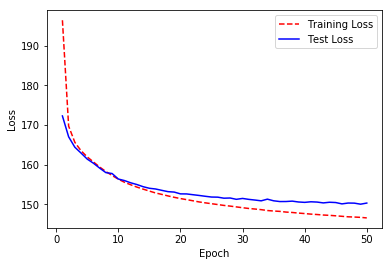

decoded_imgs.shape (10000, 784)


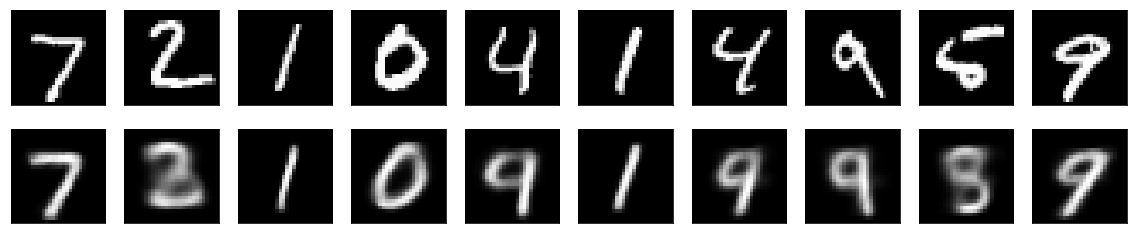

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();



decoded_imgs = vae.predict(test_images)
print("decoded_imgs.shape",decoded_imgs.shape)
import matplotlib.pyplot as plt


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()




# Further Visualization of the Variational AE Space
Given the separate encoder and decoder models, we can make two interesting plots:
1. Encoder: Here we can give the encoder real images (we will use the labeled test images for this).  Remember from above that our encoder outputs the sampled $z$ vector, but **also** the z_mean (and log_z_sigma) vector.   If our latent dimension is at the default value above of 2, we can visualize the 2D space that our encoder discovered.   Note that similar looking digits fall close to one another in this image!
2. Decoder: Here we can do something cool: since our encoder learned a functional representation of our latent space, we can provide the inputs of that function to the decoder.   Here we smoothly sample the 2D space of the z-vector from +/- 4 in both dimensions, and feed that vector to the decoder.  In the figure below, we do this in 30 steps, and then visualize the resulting 30x30 grid.


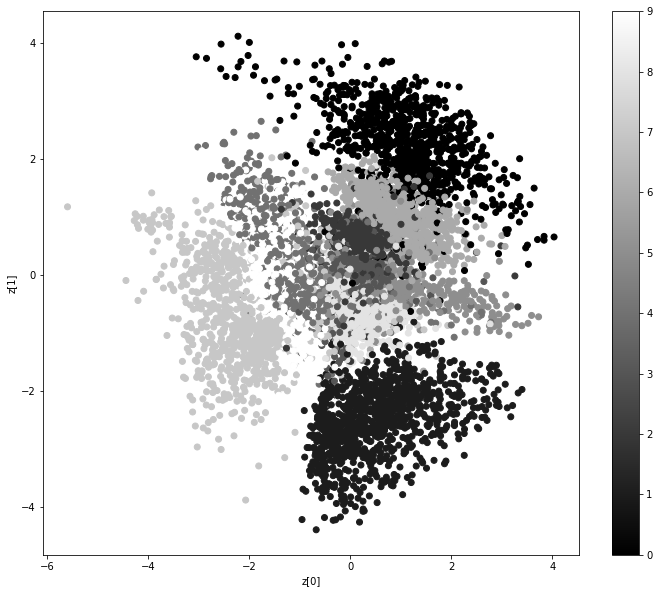

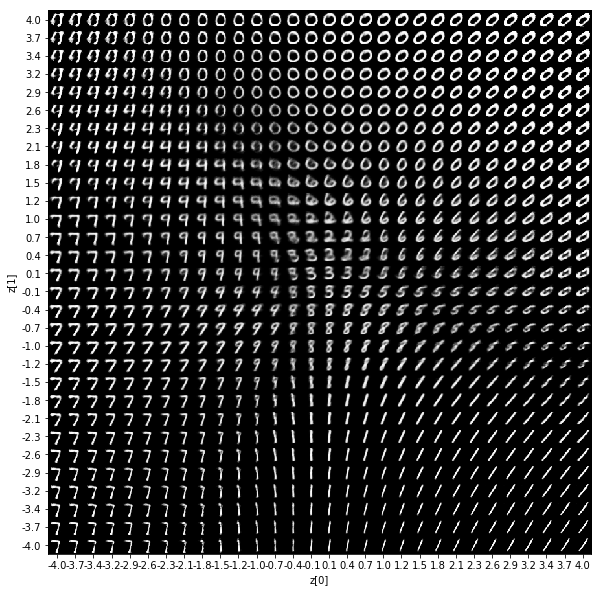

In [12]:

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

#
# Pass te encoder and decoder to the plotting routine
models = (encoder, decoder)
data = (test_images, test_labels)

plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

# Some things to try
Play with with bottleneck dimension for both the standard autoencoder as well as the variational autoencoder.

# Will this work?
It should be possible to use a latent dimension of 3, and visualize the above plots (at least the first one) in 3D.   Try it!  (Note: I have not actually done this.... so it might not work!)